In [3]:
import os

import pyart
import numpy as np
import h5py


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
def half_power_radius(r, bwhalf):
    """
    Half-power radius [m].
    Battan (1973),
    Parameters
    ----------
    r : float or array
        Range [m]
    bwhalf : float
        Half-power beam width [degrees]
        
    https://github.com/nguy/PyRadarMet/blob/master/pyradarmet/geometry.py
    """
    # Convert earth's radius to km for common dN/dH values and then
    # multiply by 1000 to return radius in meters
    return (np.asarray(r) * np.deg2rad(bwhalf)) / 2.

def beam_block_frac(th, bh, a):
    """Partial beam blockage fraction.
    Note
    ----
    Code was migrated from https://github.com/nguy/PyRadarMet.
    From Bech et al. (2003), Eqn 2 and Appendix
    Parameters
    ----------
    th : float or :class:`numpy:numpy.ndarray`
        Terrain height [m]
    bh : float or :class:`numpy:numpy.ndarray`
        Beam height [m]
    a : float or :class:`numpy:numpy.ndarray`
        Half power beam radius [m]
    Returns
    -------
    pbb : float or :class:`numpy:numpy.ndarray`
        Partial beam blockage fraction [unitless]
    Examples
    --------
    >>> pbb = beam_block_frac(th,bh,a) #doctest: +SKIP
    See :ref:`/notebooks/beamblockage/wradlib_beamblock.ipynb`.
    Note
    ----
    This procedure uses a simplified interception function where no vertical
    gradient of refractivity is considered.  Other algorithms treat this
    more thoroughly.  However, this is accurate in most cases other than
    the super-refractive case.
    See the the half_power_radius function to calculate variable `a`.
    The heights must be the same units!
    WRADLIB code
    """
    isfloat = isinstance(th, float) and isinstance(bh, float) and isinstance(a, float)

    # convert to numpy array in any case
    th = np.atleast_1d(th)
    bh = np.atleast_1d(bh)
    a = np.atleast_1d(a)

    # First find the difference between the terrain and height of
    # radar beam (Bech et al. (2003), Fig.3)
    y = th - bh

    # check if beam is clear or blocked
    ya = y / a
    clear = ya < -1.0
    block = ya > 1.0

    numer = (ya * np.sqrt(a ** 2 - y ** 2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)

    denom = np.pi * a

    pbb = numer / denom

    pbb[clear] = 0.0
    pbb[block] = 1.0

    if isfloat:
        return pbb[0]
    else:
        return pbb
    
def cum_beam_block_frac(pbb):
    """Cumulative beam blockage fraction along a beam.
    Computes the cumulative beam blockage (cbb) along a beam from the partial
    beam blockage (pbb) fraction of each bin along that beam. CBB in one bin
    along a beam will always be at least as high as the maximum PBB of the
    preceeding bins.
    Parameters
    ----------
    pbb : :class:`numpy:numpy.ndarray`
        2-D array of floats of shape (num beams, num range bins)
        Partial beam blockage fraction of a bin along a beam [m]
    Returns
    -------
    cbb : :class:`numpy:numpy.ndarray`
        Array of floats of the same shape as pbb
        Cumulative partial beam blockage fraction [unitless]
    Examples
    --------
    >>> pbb = beam_block_frac(th, bh, a) #doctest: +SKIP
    >>> cbb = cum_beam_block_frac(pbb) #doctest: +SKIP
    See :ref:`/notebooks/beamblockage/wradlib_beamblock.ipynb`.
    WRADLIB code
    """

    # This is the index of the maximum PBB along each beam
    maxindex = np.nanargmax(pbb, axis=1)
    cbb = np.copy(pbb)

    # Iterate over all beams
    for ii, index in enumerate(maxindex):
        premax = 0.0
        for jj in range(index):
            # Only iterate to max index to make this faster
            if pbb[ii, jj] > premax:
                cbb[ii, jj] = pbb[ii, jj]
                premax = pbb[ii, jj]
            else:
                cbb[ii, jj] = premax
        # beyond max index, everything is max anyway
        cbb[ii, index:] = pbb[ii, index]

    return cbb


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
climatology_ffn = '/g/data/rq0/admin/RF3_climatology/2_climatology.vol.h5'

#load climatology file
if os.path.exists(climatology_ffn):
    clim = pyart.aux_io.read_odim_h5(climatology_ffn, file_field_names=True)
else:
    print('climatology file not found', climatology_ffn)

#load peaks data
#PEAKS gives you the altitude of the highest value in the DEM for anywhere under the entire sweep arc for the given range bin. This peak may actually occur outside the nominal area covered by the range bin since while the antenna is at the CW edge of the ray half of the beam is still sampling the space nominally corresponding to the neighbouring ray on that side.
peaks = clim.fields['PEAKS']['data']

with h5py.File(climatology_ffn, 'r') as hfile:

    #load metadata
    global_how = hfile['how'].attrs
    beamwH = global_how['beamwH'] #deg
    global_where = hfile['where'].attrs
    radar_alt_asl = global_where['height'] #m asl

#calculate CCB
rg, azg = np.meshgrid(clim.range['data'], clim.azimuth['data'])
rg, eleg = np.meshgrid(clim.range['data'], clim.elevation['data'])
_, _, z = pyart.core.transforms.antenna_to_cartesian(rg / 1000.0, azg, eleg)
z_asl = z + radar_alt_asl
a = half_power_radius(rg, beamwH)
pbb = beam_block_frac(peaks, z_asl, a)
cbb = cum_beam_block_frac(pbb)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-2-9f0592de1639>:66: RuntimeWarning: invalid value encountered in sqrt
  numer = (ya * np.sqrt(a ** 2 - y ** 2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
<ipython-input-2-9f0592de1639>:66: RuntimeWarning: invalid value encountered in arcsin
  numer = (ya * np.sqrt(a ** 2 - y ** 2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)


In [37]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#load radar file
radar_ffn = '/g/data/kl02/jss548/openradar/testing_files/dp/02_20200119_050031.pvol.h5'
radar = pyart.aux_io.read_odim_h5(radar_ffn, file_field_names=True)

radar_rg  = radar.range['data']
clim_rg   = clim.range['data']
# build range mapping (Assuming it does not change between sweeps)
rg_idx = np.zeros_like(radar_rg, dtype=int)
for i, rg in enumerate(radar_rg):
    rg_idx[i] = find_nearest(clim_rg, rg)

radar_elv = radar.fixed_angle['data']
clim_elv  = clim.fixed_angle['data']

cbb_remapped = np.zeros_like(radar.fields['DBZH']['data'])

#for each sweep in the radar file
for i, elv in enumerate(radar_elv):
    #find the nearest elevation angle in the climatology
    threshold = 0.1 #maximum difference between climatology elv and radar elv
    elv_idx = find_nearest(clim_elv, elv)
    if np.abs(clim_elv[elv_idx]-elv) > threshold:
        print('cannot find radar elv of', elv, 'in climatology sweeps of', clim_elv)
        continue
    
    # extract cbb for sweep
    sweep_slice = clim.get_slice(elv_idx)
    cbb_sweep = cbb[sweep_slice]
    # build azimuith mapping (allows for changes)
    radar_az = radar.get_azimuth(i)
    clim_az = clim.get_azimuth(i)
    az_idx = np.zeros_like(radar_az, dtype=int)
    for i, az in enumerate(radar_az):
        az_idx[i] = find_nearest(clim_az, az)
    #remapp cbb for current sweep
    rg_map_idx, az_map_idx = np.meshgrid(rg_idx, az_idx)
    cbb_remapped[sweep_slice] = cbb_sweep[az_map_idx, rg_map_idx]

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.06607794761657715


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5040, 1379) (5040, 1200)


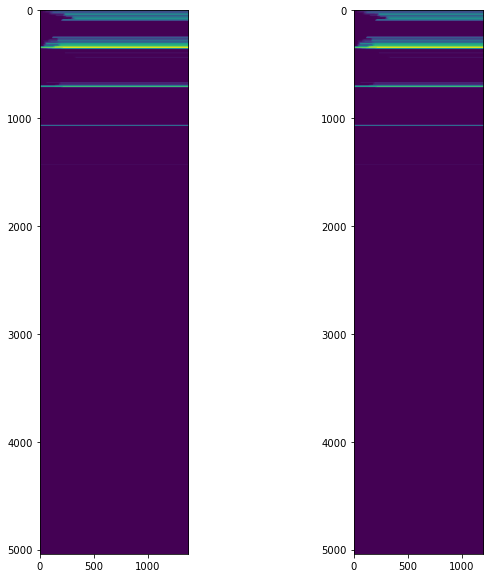

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=[10,10])
ax = plt.subplot(121)
plt.imshow(cbb)
ax = plt.subplot(122)
plt.imshow(cbb_remapped)

print(np.shape(cbb), np.shape(cbb_remapped))